Loading Fashion-MNIST dataset...


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 236kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.32MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.3MB/s]



--- Starting Training: Model 1 (Baseline) ---
Epoch 1/5 - Training Loss: 0.5000
Epoch 2/5 - Training Loss: 0.3179
Epoch 3/5 - Training Loss: 0.2740
Epoch 4/5 - Training Loss: 0.2485
Epoch 5/5 - Training Loss: 0.2318

Final Test Accuracy of Baseline Model: 91.34%


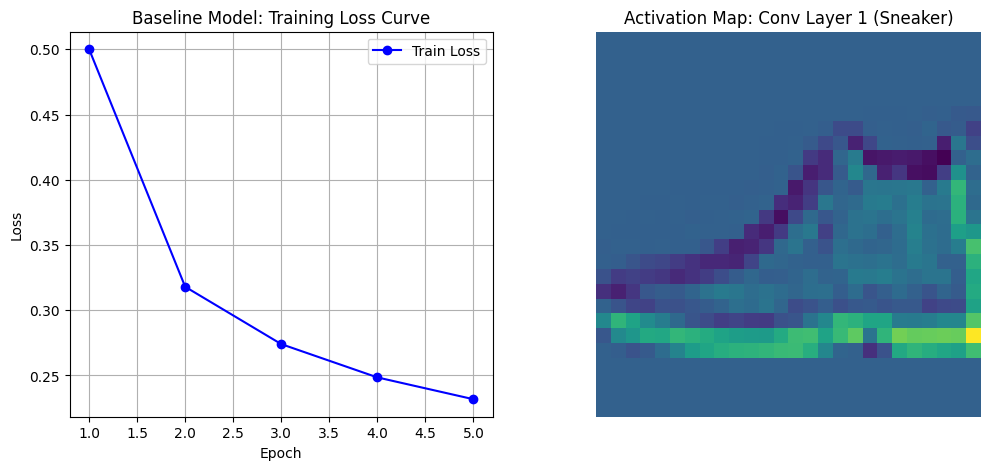

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# --- Phase 1: Data Preparation ---
# Standard normalization for Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print("Loading Fashion-MNIST dataset...")
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# --- Phase 2: Architecture Definition (Model 1 - Baseline) ---
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3), nn.ReLU(), # Layer 1
            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(), # Layer 2
            nn.MaxPool2d(2, 2), # Downsampling
            nn.Dropout(0.25) # Regularization
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 128), nn.ReLU(), # Dense layer
            nn.Dropout(0.5),
            nn.Linear(128, 10) # 10 classes output
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = BaselineCNN()
criterion = nn.CrossEntropyLoss()
# Using Adadelta optimizer with default learning rate 1.0
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

# --- Phase 3: Training Phase (5 Epochs) ---
train_losses = []
print("\n--- Starting Training: Model 1 (Baseline) ---")
model.train()
for epoch in range(5):
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # Backpropagation
        optimizer.step()
        running_loss += loss.item()

    avg_epoch_loss = running_loss/len(trainloader)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}/5 - Training Loss: {avg_epoch_loss:.4f}")

# --- Phase 4: Evaluation (Test Accuracy) ---
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nFinal Test Accuracy of Baseline Model: {100 * correct / total:.2f}%')

# --- Phase 5: Visualizations (Project Requirement P3) ---
plt.figure(figsize=(12, 5))

# Plotting the Training Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), train_losses, 'b-o', label='Train Loss')
plt.title("Baseline Model: Training Loss Curve")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

# Visualizing Activation Maps for Deep Visualization
def visualize_baseline_activations(model, loader):
    images, _ = next(iter(loader))
    sample_img = images[0].unsqueeze(0)
    with torch.no_grad():
        feature_maps = model.conv_layers[0](sample_img) # Get Conv1 features

    plt.subplot(1, 2, 2)
    plt.imshow(feature_maps[0, 0].cpu().numpy(), cmap='viridis')
    plt.title("Activation Map: Conv Layer 1 (Sneaker)")
    plt.axis('off')
    plt.show()

visualize_baseline_activations(model, testloader)